# Część na 3.0

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from bresenham import bresenham
import imageio
import pydicom
from pydicom.data import get_testdata_files
from scipy import ndimage
from scipy.fftpack import fft, ifft, fftfreq

In [32]:
alfa = 1
n = 150
l = 90

In [33]:

def emiterPosition(angle, i, n, r, l, offset):
    x = r * np.cos( np.radians(angle) ) + offset[0]
    y = r * np.sin( np.radians(angle) ) + offset[1]
    return (x,y)

In [34]:

def sensorPosition(angle, i, n, r, l, offset):
    x = r * np.cos( np.radians(angle) + np.pi - np.radians(l)/2 + i * ( np.radians(l) / (n-1) ) ) + offset[0]
    y = r * np.sin( np.radians(angle) + np.pi - np.radians(l)/2 + i * ( np.radians(l) / (n-1) ) ) + offset[1]
    return (x,y)

In [35]:
"""
Symulacja laseru przechodzącego liniowo przez obraz image z punktu start do punktu end.
Należy policzyć, ile mocy lasera zostanie pochłonięte, skorzystaj z funkcji bresenham
"""
def beam(image, start, end):
    w, h = image.shape
    x = bresenham(int(start[0]), int(start[1]), int(end[0]), int(end[1]))
    y = np.array(list(x))
    y = y[y[:,0] >= 0]
    y = y[y[:,0] < w]
    y = y[y[:,1] >= 0]
    y = y[y[:,1] < h]
    return np.sum(image[y[:,0],y[:,1]])

In [36]:
def makeGif(gif, filename):
    scale = gif[-1].max()
    gif = list(map(lambda x: (x/scale*255).astype(np.uint8), gif))
    imageio.mimsave(filename+".gif", gif)

In [37]:
def radon_iwm(img_gray, alfa, n, l, R, gifFlag=True, filter=False):   
    gif = []
    gif_f = []
    result = np.zeros((n, len(np.arange(-90,90,alfa))))
    result_filtered = np.zeros((n, len(np.arange(-90,90,alfa))))
    for i,angle in enumerate(np.arange(-90,90,alfa)[::-1]):
        result[..., i] = np.array([beam(img_gray, 
                                         emiterPosition(angle, sensor, n, R, l, (img_gray.shape[1]/2, img_gray.shape[0]/2)),
                                         sensorPosition(angle, sensor, n, R, l, (img_gray.shape[1]/2, img_gray.shape[0]/2)))
                                   for sensor in range(n)])
        if gifFlag:
            gif.append(result.copy())
    if gifFlag:
        makeGif(gif, "radon")
    if filter:
        sinogram = result.copy()
        f = fftfreq(sinogram.shape[0]).reshape(-1, 1)
        fourier_filter = 2 * np.abs(f)

        projection = fft(sinogram, axis=0) * fourier_filter
        sinogram = np.real(ifft(projection, axis=0))
        return sinogram/sinogram.max()
    return result/result.max()

In [38]:
def inverseRadon_iwn(radon, shape, alfa, n, l, R, gifFlag=True, filter=False):
    width, height = shape
    gif = []
    result = np.zeros(shape)
    R = max(shape)*2**.5+10
    for i, angle in enumerate(np.arange(-90,90,alfa)[::-1]):
        for sensor in range(n):
            start = emiterPosition(angle, sensor, n, R, l, (shape[1]/2, shape[0]/2))
            end = sensorPosition(angle, sensor, n, R, l, (shape[1]/2, shape[0]/2))

            x = bresenham(int(start[0]), int(start[1]), int(end[0]), int(end[1]))
            y = np.array(list(x))
            y = y[y[:,0] >= 0]
            y = y[y[:,0] < width]
            y = y[y[:,1] >= 0]
            y = y[y[:,1] < height]
            
            
            result[y[:,0], y[:,1]] += radon[sensor][i]
        if gifFlag:
            gif.append(result.copy()/result.max())
    if gifFlag:
        makeGif(gif, "inverse")
    return result/result.max()

In [39]:
def projekt1(file, alfa, n, l,gifFlag, filter):
    img = plt.imread(file)
    img_gray = img[...,0]
    plt.imshow(img_gray)
    R = (max(img_gray.shape))*2**.5+10 
    radon = radon_iwm(img_gray, alfa, n, l, R, gifFlag, filter)
    plt.imshow(radon, cmap=plt.cm.bone)
    plt.show()
    iradon = inverseRadon_iwn(radon, img_gray.shape, alfa, n, l, R, gifFlag, filter)
    plt.imshow(iradon, cmap=plt.cm.bone)
    plt.show()
    return iradon

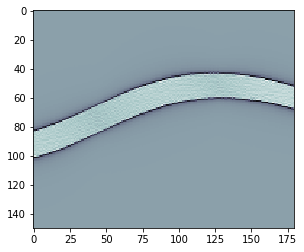

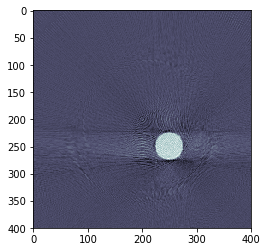

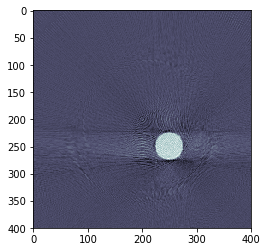

In [47]:

iradon = projekt1("Kropka.jpg", alfa, n, l, gifFlag=False, filter=True)
plt.imshow(iradon, cmap=plt.cm.bone)
plt.show()

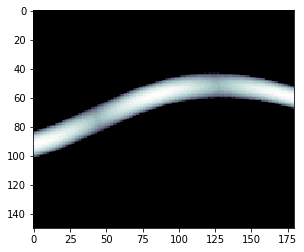

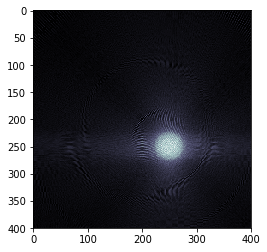

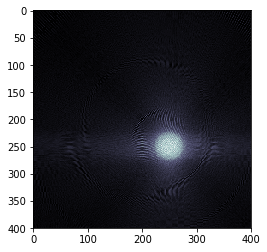

In [41]:
iradon = projekt1("Kropka.jpg", alfa, n, l,gifFlag=False, filter=False)
plt.imshow(iradon, cmap=plt.cm.bone)
plt.show()

## Część na 4.0

In [48]:
import os
import tempfile
import datetime

import pydicom
from pydicom import dcmread
from pydicom.dataset import Dataset, FileDataset

In [49]:
def write_dicom(array, filename="iradon.dcm", name="Test^Firstname", patientID="123456"):
    # Create some temporary filenames
    print("Setting file meta information...")
    filename_little_endian = tempfile.NamedTemporaryFile(suffix=".dcm").name
    # Populate required values for file meta information
    file_meta = Dataset()
    file_meta.MediaStorageSOPClassUID = '1.2.840.10008.5.1.4.1.1.2'
    file_meta.MediaStorageSOPInstanceUID = "1.2.3"
    file_meta.ImplementationClassUID = "1.2.3.4"

    print("Setting dataset values...")
    # Create the FileDataset instance (initially no data elements, but file_meta
    # supplied)
    ds = FileDataset(filename_little_endian, {},
                     file_meta=file_meta, preamble=b"\0" * 128)

    # Add the data elements -- not trying to set all required here. Check DICOM
    # standard
    ds.PatientName = name
    ds.PatientID = patientID

    # Set the transfer syntax
    ds.is_little_endian = True
    ds.is_implicit_VR = True

    # Set creation date/time
    dt = datetime.datetime.now()
    ds.ContentDate = dt.strftime('%Y%m%d')
    timeStr = dt.strftime('%H%M%S.%f')  # long format with micro seconds
    ds.ContentTime = timeStr

    # Set pixel array
    ds.PixelData = np.array(array*255, dtype=np.int8).tobytes() #create photo in bits
    ds.Rows, ds.Columns = array.shape # shape
    ds.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
    
    ds.PixelRepresentation = 0 
    ds.BitsAllocated = 8 # 8bitów na pixels
    ds.SamplesPerPixel = 1 # black photo 
    ds.NumberOfFrames = 1 # it is photo 
    ds.PhotometricInterpretation = "MONOCHROME"
    ds.PlanarConfiguration = 0
    
    print("Writing test file", filename_little_endian)
    ds.save_as(filename)
    print("File saved.")

In [50]:
write_dicom(iradon)

Setting file meta information...
Setting dataset values...
Writing test file /var/folders/61/pz32fmy55zz1vsl70y6wvj900000gn/T/tmptv2a0_ze.dcm
File saved.


In [51]:
def readDicom(filename="iradon.dcm"):
    ds = dcmread(filename)
    # Load dimensions based on the number of rows, columns, and slices (along the Z axis)
    ConstPixelDims = (int(ds.Rows), int(ds.Columns))

    ArrayDicom = np.zeros(ConstPixelDims, dtype=np.int8)
    ArrayDicom = ds.pixel_array 

    plt.imshow(ArrayDicom, cmap=plt.cm.bone)
    plt.show()

    return ArrayDicom

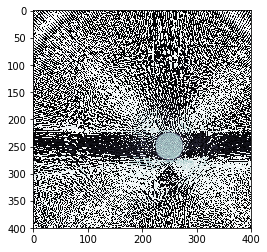

array([[  6, 253, 254, ...,   2,   0,   0],
       [251,   6, 251, ...,   1,   5,   0],
       [254, 250,   0, ...,   4,   5, 248],
       ...,
       [  9, 253, 252, ..., 249,   3,   3],
       [250, 251, 255, ...,   4, 249, 255],
       [  0, 255, 254, ...,   4,   0,   0]], dtype=uint8)

In [52]:
readDicom()